# AVALIAÇÃO DE RISCO DE CRÉDITO

O negócio bancário tem como principal know-how a capacidade de gerenciamento de risco financeiro. O cálculo da taxa de inadimplência de um carteira de crédito desempenha papel fundamental no desempenho e planejamento de uma instituição financeira.

O objetivo destes cálculos é identificar a probabilidade de um cliente entrar em default que é o não cumprimento de uma obrigação ou condição de um empréstimo, sendo que normalmente sua causa é a incapacidade financeira do cliente.

Instituições pelo mundo têm incorporado o uso de modelos de machine learning para o aprimoramento de sua avaliação de risco. Neste contexto, temos uma base de dados da fintech Nubank que será utilizada para modelagem afim de predizer a probabilidade de default para seus clientes.

# IMPORTANDO DADOS E BIBLIOTECAS

In [2]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# importar algoritmos e metricas
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ks_2samp
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV
from matplotlib.legend_handler import HandlerLine2D

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
db = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

# ANALISANDO OS DADOS

## Prévia dos dados

In [4]:
db.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


In [5]:
print(80*'*')
print(f'Dimensões: {db.shape[0]} linhas e {db.shape[1]} colunas.\n')
print(80*'*')
print(f'Colunas: {db.columns.values}\n')
print(80*'*')
print('Tipos:', '\n\n'+str(db.dtypes)+'\n')
print(80*'*')
print('Quantidade de valores únicos: ', '\n\n'+str(db.nunique()))
print('\n'+80*'*')
print('Prévia dos valores: \n')
for col in db.columns.values:
  if len(db[col].unique()) > 5:
    print('\n'+col+': ', db[col].unique()[:5], 'entre outros...')
  else:
    print('\n'+col+': ', db[col].unique())
print('\n'+80*'*')
print('Estatística Descritiva: \n\n', db.describe().to_string(max_cols=db.shape[1]))
print('\n'+80*'*')
print('Valores Nulos:', '\n\n'+str((db.isnull().sum()/db.shape[0]).sort_values(ascending=False))+'\n\n')
print('\n'+80*'*')
num_but_cat = [col for col in db.columns if db[col].nunique() < 10 and db[col].dtypes != "O"]
cat_but_car = [col for col in db.columns if db[col].nunique() > 20 and db[col].dtypes == "O"]
print('Variáveis numéricas que podem ser categoricas: ', num_but_cat)
print('Variáveis categóricas com cardinalidade: ', cat_but_car)

********************************************************************************
Dimensões: 45000 linhas e 43 colunas.

********************************************************************************
Colunas: ['ids' 'target_default' 'score_1' 'score_2' 'score_3' 'score_4' 'score_5'
 'score_6' 'risk_rate' 'last_amount_borrowed' 'last_borrowed_in_months'
 'credit_limit' 'reason' 'income' 'facebook_profile' 'state' 'zip'
 'channel' 'job_name' 'real_state' 'ok_since' 'n_bankruptcies'
 'n_defaulted_loans' 'n_accounts' 'n_issues' 'application_time_applied'
 'application_time_in_funnel' 'email'
 'external_data_provider_credit_checks_last_2_year'
 'external_data_provider_credit_checks_last_month'
 'external_data_provider_credit_checks_last_year'
 'external_data_provider_email_seen_before'
 'external_data_provider_first_name' 'external_data_provider_fraud_score'
 'lat_lon' 'marketing_channel' 'profile_phone_number' 'reported_income'
 'shipping_state' 'shipping_zip_code' 'profile_tags' 'user_ag

## Sumário

O dataset possui 45000 linhas e 43 colunas.

A variável target para risco de default está armazenada na coluna `target_default`.

A base de dados possui colunas codificadas são elas: <br>
* `['ids', 'score_1', 'score_2','reason', 'state', 'zip', 'channel', 'job_name', 'real_state']`

Features relacionadas a cadastro de clientes:
<br>
* `['facebook_profile', 'email', 'shipping_state', 'shipping_zip_code','profile_phone_number','profile_tags', 'income', 'reported_income', 'marketing_channel']`

Features relacionadas a análise de crédito:
* `['score_3','score_4', 'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues']`

Features derivadas de bureaus de crédito:
* `['external_data_provider_credit_checks_last_2_year', 'external_data_provider_credit_checks_last_month', 'external_data_provider_credit_checks_last_year', 'external_data_provider_fraud_score']`

Alguns dados de telemetria: <br>
* `['user_agent','application_time_applied', 'application_time_in_funnel']`

As variáveis abaixo demandam aprofundamento em sua sistemática para compreensão da informação:

* `['ok_since','external_data_provider_email_seen_before','external_data_provider_first_name',  'lat_lon']`


# SELEÇÃO DE FEATURES

Considerando a informação contida e sua utilidade removeremos as seguintes colunas:



*   Variáveis cadastrais/contato de clientes: <br>
`['ids', 'profile_phone_number', 'email', 'marketing_channel']`

*   Valores codificados: <br>
`['ids', 'score_1', 'score_2','reason', 'state', 'zip', 'channel', 'job_name', 'real_state']`

*   Telemetria: <br>
`['user_agent','application_time_applied', 'application_time_in_funnel']`

*   Demandam maior aprofundamento: <br>
`['ok_since','external_data_provider_email_seen_before','external_data_provider_credit_checks_last_2_year', 'external_data_provider_first_name',  'lat_lon', 'shipping_state', 'shipping_zip_code']`

* Scores sem informação sobre origem ou método de cálculo: <br>
`['risk_rate', 'score_3', 'score_4', 'score_5', 'score_6', 'external_data_provider_fraud_score']`

* Variável target para detecção de fraude: <br>
`['target_fraud]`



Teremos então as seguintes features para o treinamento do modelo:

* `last_amount_borrowed`: Último valor emprestado.

* `last_borrowed_in_months`: Quantos meses do último empréstimo.

* `credit_limit`: Limite de crédito.

* `income`: Renda.

* `reported_income`: Renda informada pelo cliente.

* `facebook_profile`: Perfil do facebook conhecido/informado.

* `n_bankruptcies`: quantidade de falências/defaults.

* `n_defaulted_loans`: Quantidade de empréstimos com default.

* `n_accounts`: Número de contas.

* `n_issues`: Número de solicitações de crédito.

* `external_data_provider_credit_checks_last_month`: Quantidade de checagens no bureau de crédito no último mês.

* `external_data_provider_credit_checks_last_year`: Quantidade de checagens no bureau de crédito no último ano.



In [6]:
df = db.drop(['ids', 'profile_phone_number', 'email', 'marketing_channel', 'score_1', 'score_2', 'risk_rate', 'score_3', 'score_4', 'score_5', 'score_6','reason', 'state', 'zip', 'channel', 'job_name', 'real_state',
          'user_agent','application_time_applied', 'application_time_in_funnel', 'ok_since','external_data_provider_email_seen_before',
          'external_data_provider_credit_checks_last_2_year', 'external_data_provider_first_name', 'external_data_provider_fraud_score', 'lat_lon', 'profile_tags','shipping_state', 'shipping_zip_code', 'target_fraud'], axis=1).copy()
print(df.head().to_string(max_cols=df.shape[1]))

  target_default  last_amount_borrowed  last_borrowed_in_months  credit_limit     income facebook_profile  n_bankruptcies  n_defaulted_loans  n_accounts  n_issues  external_data_provider_credit_checks_last_month  external_data_provider_credit_checks_last_year  reported_income
0          False              25033.92                     36.0           0.0   65014.12             True             0.0                0.0        18.0      18.0                                                2                                             0.0          57849.0
1          False                   NaN                      NaN       39726.0  100018.91            False             0.0                0.0        14.0      14.0                                                1                                             0.0           4902.0
2           True               7207.92                     36.0           NaN   65023.65              NaN             0.0                0.0        10.0       NaN       

# MISSING/NULOS


In [7]:
print('Valores Nulos:', '\n\n'+str((df.isnull().sum()/df.shape[0]).sort_values(ascending=False))+'\n\n')

Valores Nulos: 

last_amount_borrowed                               0.665689
last_borrowed_in_months                            0.665689
external_data_provider_credit_checks_last_year     0.336089
credit_limit                                       0.306667
n_issues                                           0.256533
facebook_profile                                   0.099067
target_default                                     0.072422
n_bankruptcies                                     0.015489
n_defaulted_loans                                  0.012756
income                                             0.012489
n_accounts                                         0.012489
external_data_provider_credit_checks_last_month    0.000000
reported_income                                    0.000000
dtype: float64




Analisando o resumo da estatística descritiva somos capazes de destacar algumas observações:

* `['reported_income']` possui valores infinitos, que não fazem sentido no contexto de renda.

* `['last_amount_borrowed','last_borrowed_in_months']` possui > 50% de valores ausentes.

* `['external_data_provider_credit_checks_last_year', 'credit_limit', 'n_issues']` possui >25% de valores ausentes.

* `['facebook_profile]` terá valores NA substituídos por False (não possui).

* Excluiremos registros que possuem valores nulos para `['n_bankruptcies', 'n_defaulted_loans','reported_income']`

In [8]:
#Preencheremos valores 0 para nulos.

df['last_amount_borrowed'].fillna(value=0, inplace=True)
df['last_borrowed_in_months'].fillna(value=0, inplace=True)
df['external_data_provider_credit_checks_last_year'].fillna(value=0, inplace=True)
df['credit_limit'].fillna(value=0, inplace=True)
df['n_issues'].fillna(value=0, inplace=True)
df['facebook_profile'].fillna(value=False, inplace=True)

#Removeremos valores inválidos para as demais variáveis.
rows = df.shape[0]
df.dropna(subset=['target_default'], inplace=True)
print(f'target_default: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df['reported_income'] = df['reported_income'].replace(np.inf, np.nan)
df.dropna(subset=['reported_income'], inplace=True)
print(f'reported_income: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df.dropna(subset=['income'], inplace=True)
print(f'income: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df.dropna(subset=['n_bankruptcies'], inplace=True)
print(f'n_bankruptcies: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df.dropna(subset=['n_defaulted_loans'], inplace=True)
print(f'n_defaulted_loans: {rows - df.shape[0]} linhas excluídas.')
rows=df.shape[0]

df = df.copy().reset_index(drop=True)

target_default: 3259 linhas excluídas.
reported_income: 66 linhas excluídas.
income: 0 linhas excluídas.
n_bankruptcies: 135 linhas excluídas.
n_defaulted_loans: 0 linhas excluídas.


In [9]:
print('Valores Nulos:', '\n\n'+str((df.isnull().sum()/df.shape[0]).sort_values(ascending=False))+'\n\n')

Valores Nulos: 

target_default                                     0.0
last_amount_borrowed                               0.0
last_borrowed_in_months                            0.0
credit_limit                                       0.0
income                                             0.0
facebook_profile                                   0.0
n_bankruptcies                                     0.0
n_defaulted_loans                                  0.0
n_accounts                                         0.0
n_issues                                           0.0
external_data_provider_credit_checks_last_month    0.0
external_data_provider_credit_checks_last_year     0.0
reported_income                                    0.0
dtype: float64




# FEATURES x TARGET

In [10]:
df['target_default'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

False    84.0%
True     16.0%
Name: target_default, dtype: object

In [11]:
df['target_default'].value_counts()

False    34909
True      6631
Name: target_default, dtype: int64

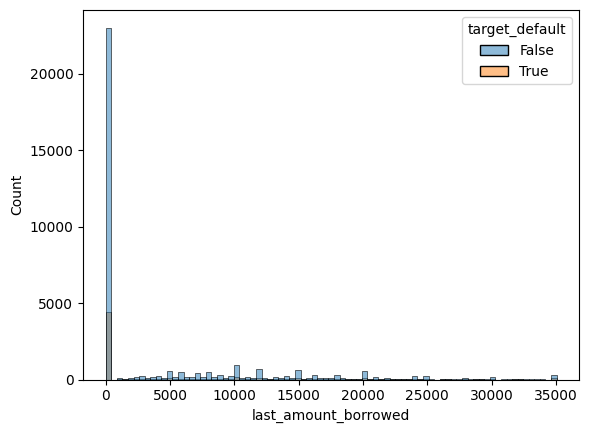

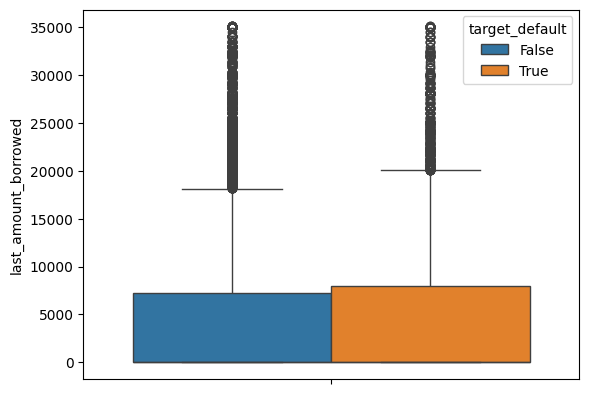

In [12]:
sns.histplot(data=df, x='last_amount_borrowed', hue='target_default')
plt.show()
sns.boxplot(data=df, y='last_amount_borrowed', hue='target_default')
plt.show()

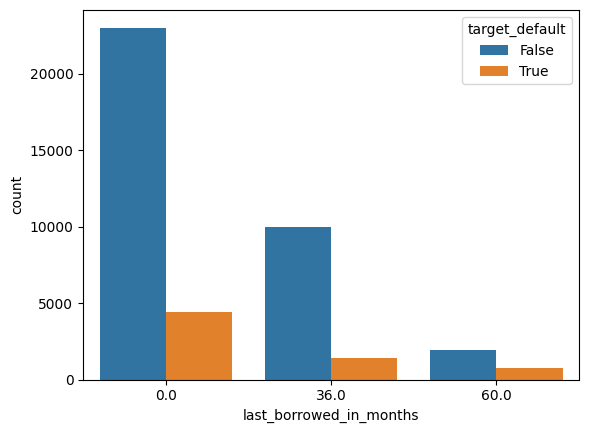

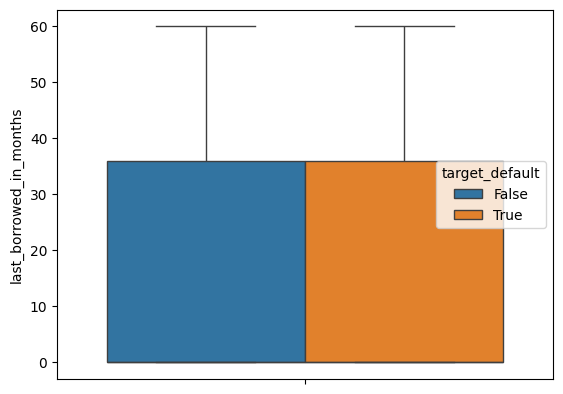

In [13]:
sns.countplot(data=df, x='last_borrowed_in_months', hue='target_default')
plt.show()
sns.boxplot(data=df, y='last_borrowed_in_months', hue='target_default')
plt.show()

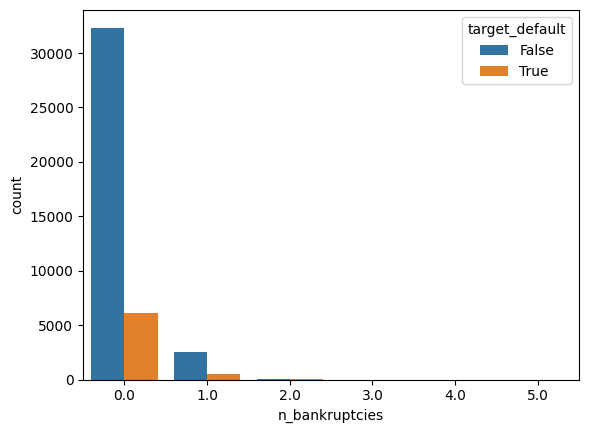

In [14]:
sns.countplot(data=df, x='n_bankruptcies', hue='target_default')
plt.show()

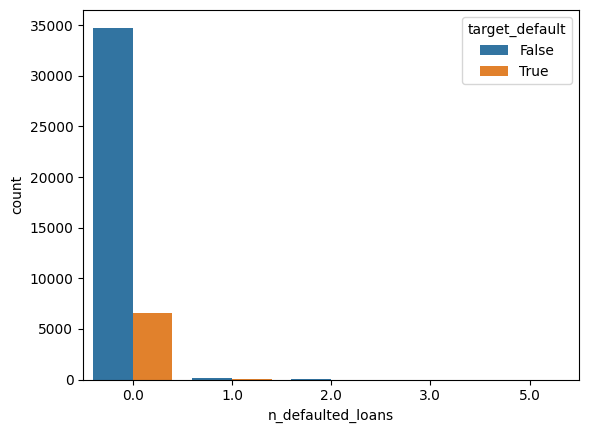

In [15]:
sns.countplot(data=df, x='n_defaulted_loans', hue='target_default')
plt.show()

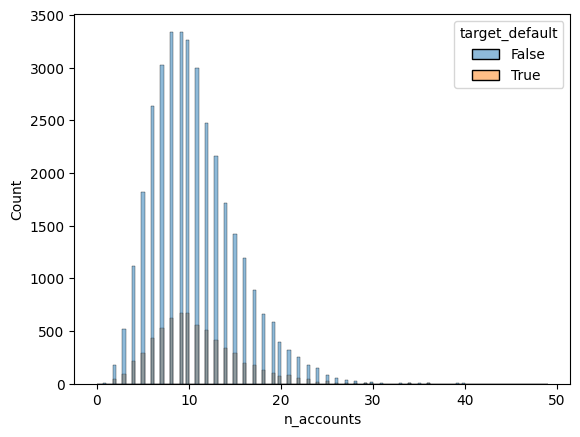

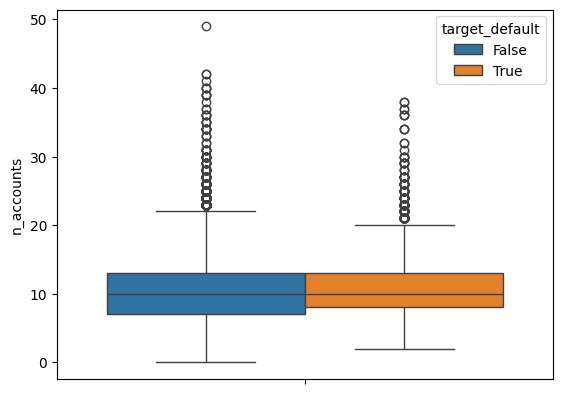

In [16]:
sns.histplot(data=df, x='n_accounts', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_accounts', hue='target_default')
plt.show()

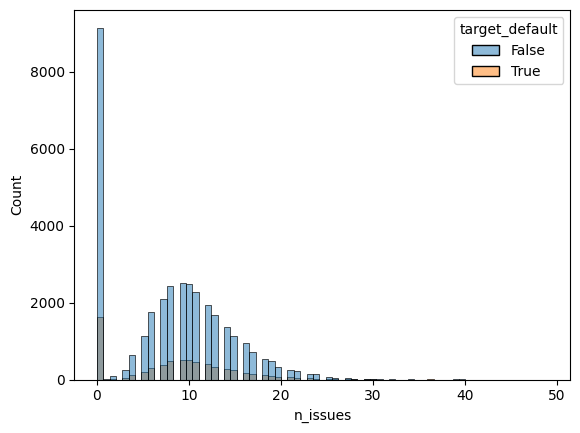

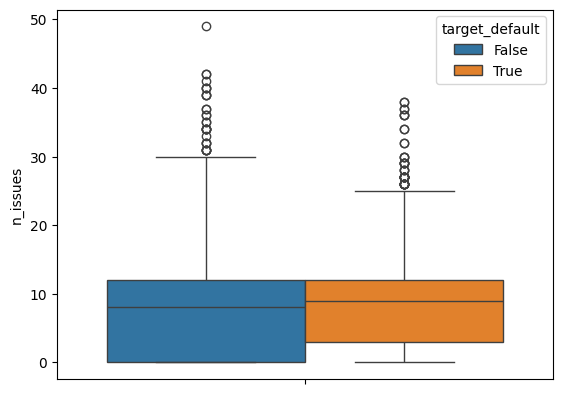

In [17]:
sns.histplot(data=df, x='n_issues', hue='target_default')
plt.show()
sns.boxplot(data=df, y='n_issues', hue='target_default')
plt.show()

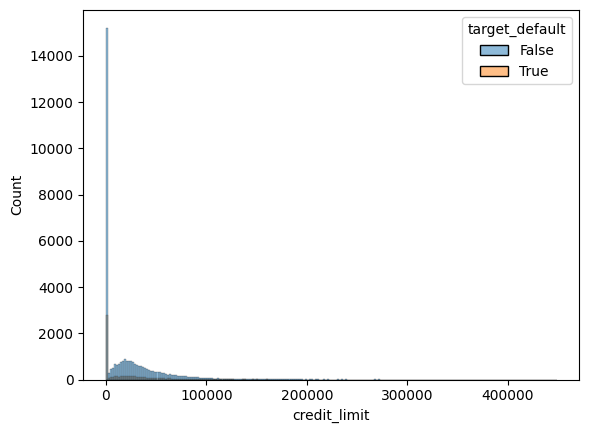

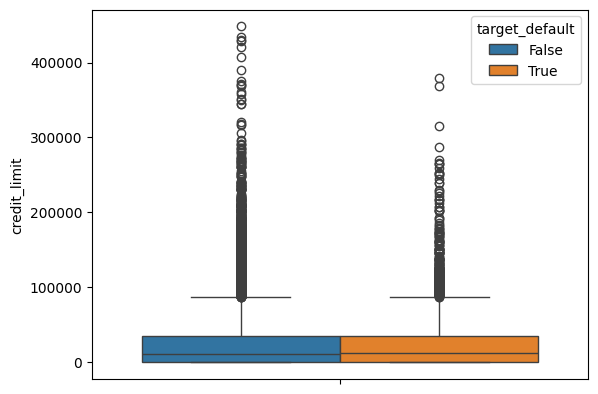

In [18]:
sns.histplot(data=df, x='credit_limit', hue='target_default')
plt.show()
sns.boxplot(data=df, y='credit_limit', hue='target_default')
plt.show()

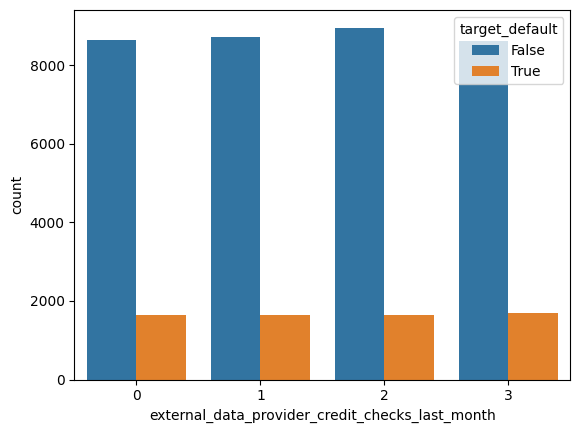

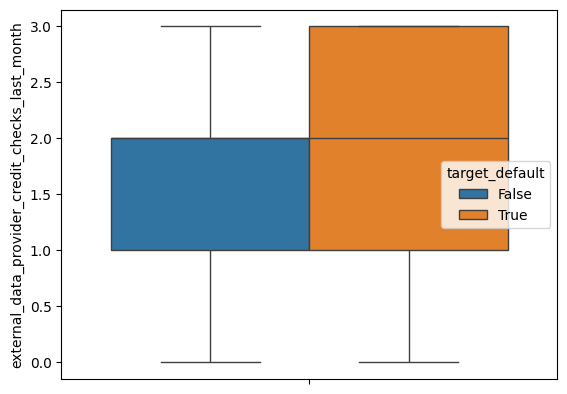

In [19]:
sns.countplot(data=df, x='external_data_provider_credit_checks_last_month', hue='target_default')
plt.show()
sns.boxplot(data=df, y='external_data_provider_credit_checks_last_month', hue='target_default')
plt.show()

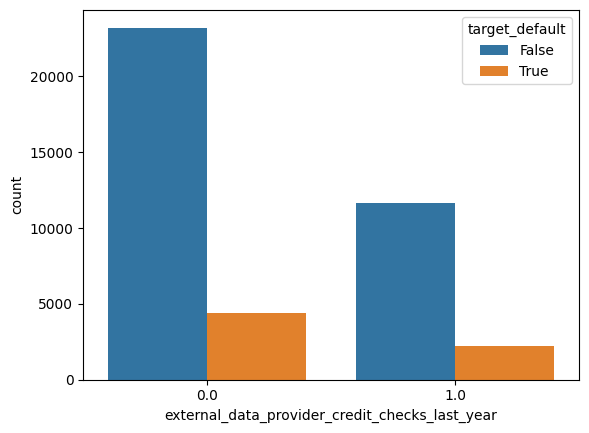

In [20]:
sns.countplot(data=df, x='external_data_provider_credit_checks_last_year', hue='target_default')
plt.show()

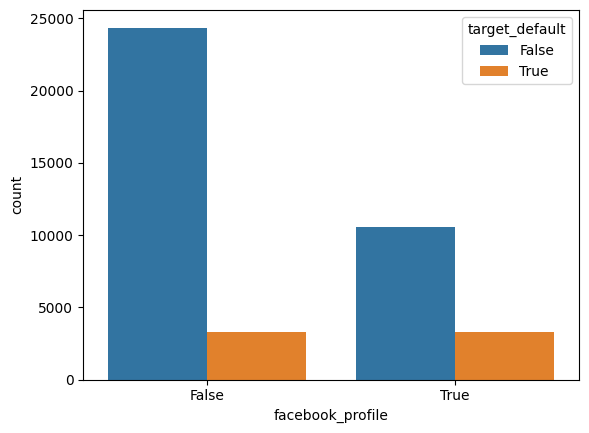

In [21]:
sns.countplot(data=df, x='facebook_profile', hue='target_default')
plt.show()

# OUTLIERS

Avaliando `income (renda)` e `reported income (Renda informada)` constatamos a existência de outliers. Realizaremos a regularização destes dados retirando os registros com renda informada acima de R$ 1.000.000.

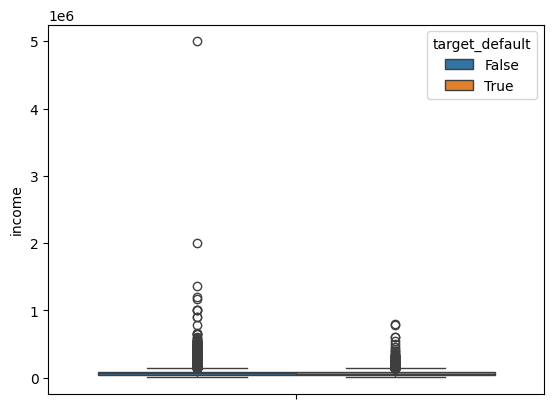


Renda acima de 1.000.000: 8


In [22]:
sns.boxplot(data=df, y='income', hue='target_default')
plt.show()

c = df[df['income'] >= 1e6]['income'].count()
print(f'\nRenda acima de 1.000.000: {c}')

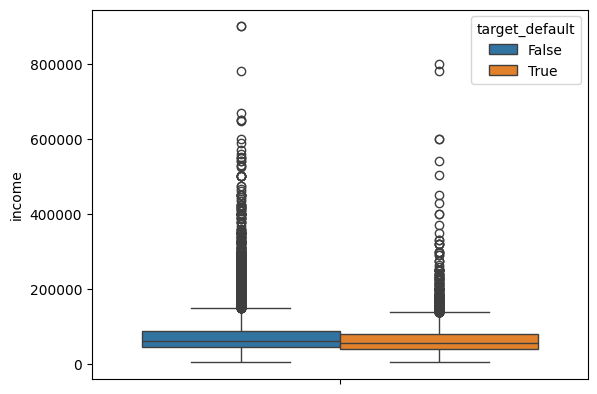

In [23]:
#Removendo Renda acima de 1.000.000
df = df[df['income'] <= 1e6].copy()
sns.boxplot(data=df, y='income', hue='target_default')
plt.show()

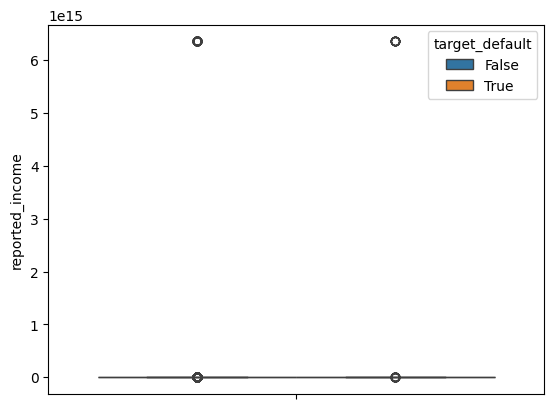


Renda informada acima de 1.000.000: 314


In [24]:
sns.boxplot(data=df, y='reported_income', hue='target_default')
plt.show()

c = df[df['reported_income'] >= 1e6]['reported_income'].count()
print(f'\nRenda informada acima de 1.000.000: {c}')

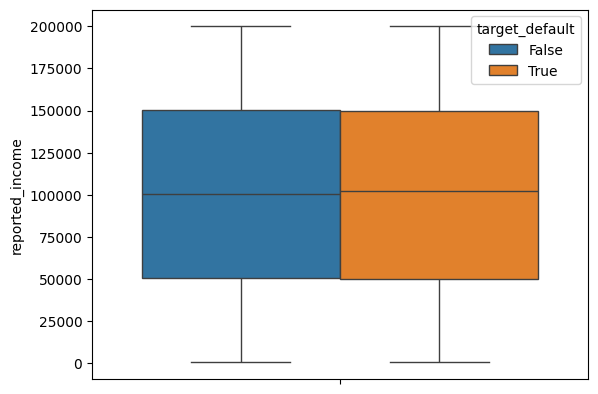

In [25]:
df = df[df['reported_income'] <= 1e6].copy()
sns.boxplot(data=df, y='reported_income', hue='target_default')
plt.show()

# PADRONIZANDO OS DADOS

In [26]:
lbl_y = 'target_default'

def data_prep(df, lbl_y):
  scaled_df = df.copy()

  # normalizar as colunas numéricas
  num_cols = scaled_df.drop(lbl_y, axis=1).select_dtypes(exclude='object').columns
  scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)
  encoded_df = scaled_df.copy()

  # extrair as colunas categóricas
  cat_cols = encoded_df.select_dtypes('object').columns

  # codificar cada coluna categórica
  for col in cat_cols:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

  return encoded_df

In [27]:
# normalizando numéricas e codificando categóricas.
encoded_df = data_prep(df, lbl_y)

# IV e VIF

In [28]:
def show_VIF(df, feature_cols):
  # the independent variables set
  X = df[feature_cols].copy()
  X['intercept'] = 1

  # VIF dataframe
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns

  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

  vif_data = vif_data.sort_values(by='VIF', ascending=False)

  print("\n", vif_data)

In [29]:
feature_cols = list(df.drop(['target_default'], axis=1).columns)

In [30]:
show_VIF(encoded_df,feature_cols)


                                             feature       VIF
0                              last_amount_borrowed  3.601624
1                           last_borrowed_in_months  3.519281
8                                          n_issues  2.203637
7                                        n_accounts  1.839804
2                                      credit_limit  1.457952
3                                            income  1.176679
5                                    n_bankruptcies  1.008671
6                                 n_defaulted_loans  1.001595
10   external_data_provider_credit_checks_last_year  1.000556
11                                  reported_income  1.000311
4                                  facebook_profile  1.000294
9   external_data_provider_credit_checks_last_month  1.000123
12                                        intercept  1.000000


Considerando VIF > 5 para sinais de multicolinearidade não encontramos pontos de atenção.

In [31]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [round(d['IV'].sum(), 4)]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

    newDF['Level'] = 'Very Weak'
    newDF.loc[(newDF['IV'] > 0.02) & (newDF['IV'] < 0.1), 'Level'] = 'Weak'
    newDF.loc[(newDF['IV'] > 0.1) & (newDF['IV'] < 0.3), 'Level'] = 'Average'
    newDF.loc[(newDF['IV'] > 0.3) & (newDF['IV'] < 0.5), 'Level'] = 'Strong'
    newDF.loc[(newDF['IV'] > 0.5), 'Level'] = 'Suspicious'

    newDF = newDF.sort_values(by='IV', ascending=False)
    #Show WOE Table
    if show_woe == True:
        print("\n", newDF)

    return newDF, woeDF

In [32]:
newDF, woeDF = iv_woe(encoded_df, lbl_y, bins=100, show_woe=True)


                                           Variable      IV      Level
0                                 facebook_profile  0.1634    Average
0                          last_borrowed_in_months  0.0712       Weak
0                                           income  0.0456       Weak
0                                  reported_income  0.0223       Weak
0                             last_amount_borrowed  0.0168  Very Weak
0                                     credit_limit  0.0116  Very Weak
0                                         n_issues  0.0084  Very Weak
0                                       n_accounts  0.0081  Very Weak
0                                   n_bankruptcies  0.0016  Very Weak
0                                n_defaulted_loans  0.0011  Very Weak
0  external_data_provider_credit_checks_last_month  0.0007  Very Weak
0   external_data_provider_credit_checks_last_year  0.0000  Very Weak


Para features relacionadas a risco de crédito mais óbvias temos IV Fraco ou Muito Fraco. Temos IV médio para facebook_profile, seria interessante verificar com a àrea de negócio a sistemática de cadastro desta informação e um estudo mais aprofundado da mesma.

# CORRELAÇÃO

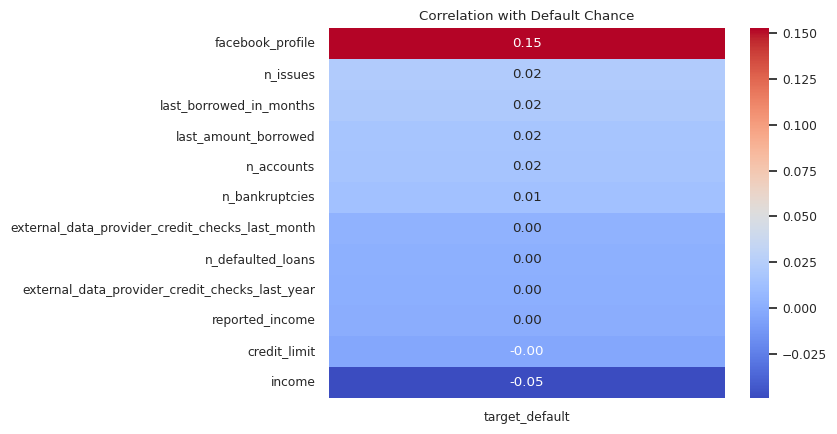

In [33]:
corr = encoded_df.corr()
target_corr = corr['target_default'].drop('target_default')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Default Chance')
plt.show()

As correlações levantadas são bastante fracas porém em linha com o presumido para risco de crédito exceto para `facebook_profile`.

Aumentam o risco de default:

* `Número de solicitações de crédito` (n_issues), `endividamento` (last_borrowed_months e last_amount_borrowed) e `número de falências` (n_bankruptcies).

Reduzem o risco de default:

* `Limite de crédito` (credit_limit) e `income` (income) representando a confiança na capacidade de pagamento.


# SPLIT PARA TREINO E TESTE

In [34]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop(lbl_y, axis=1)
y = encoded_df[lbl_y]

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TREINAMENTO DOS MODELOS

Agruparemos o código para treinamento e cálculo das métricas em uma função.

In [35]:
def encontra_melhor_modelo(X_train, X_test, y_train, y_test, metrica='balanced_accuracy'):

  # Definindo os modelos
  modelos = [
      ('Logistic Regression', LogisticRegression(max_iter=1000)),
      ('Random Forest', RandomForestClassifier()),
      ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
  ]

  # Treinamento dos modelos, avaliação e seleção.
  melhor_modelo = None
  melhor_score = -np.inf

  print("Performance dos Modelos:")
  for nome, modelo in modelos:
      modelo.fit(X_train, y_train)

      y_pred = modelo.predict(X_test)

      #sorting model for desired metric
      if metrica == 'accuracy':
        accuracy = metrics.accuracy_score(y_test, y_pred)
        metrica_valor = metrica_valor
        print(f"{nome} - Acurácia: {metrica_valor:.5f}")

      elif metrica == 'balanced_accuracy':
        balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
        metrica_valor = balanced_accuracy
        print(f"{nome} - Acurácia Balanceada: {metrica_valor:.5f}")

      elif metrica == 'f1':
        f1 = metrics.f1_score(y_test, y_pred)
        metrica_valor = f1
        print(f"{nome} - F1: {metrica_valor:.5f}")

      elif metrica == 'recall':
        recall = metrics.recall_score(y_test, y_pred)
        metrica_valor = recall
        print(f"{nome} - Recall: {metrica_valor:.5f}")

      elif metrica == 'precision':
        precision = metrics.precision_score(y_test, y_pred)
        metrica_valor = precision
        print(f"{nome} - Precision: {metrica_valor:.5f}")

      elif metrica == 'roc_auc':
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        metrica_valor = roc_auc
        print(f"{nome} - roc_auc: {metrica_valor:.5f}")

      if metrica_valor > melhor_score:
          melhor_score = metrica_valor
          melhor_modelo = modelo
          melhor_modelo_nome = nome

  print(f"\nMelhor modelo: {melhor_modelo_nome} com {metrica}: {melhor_score:.4f}")

  accuracy = metrics.accuracy_score(y_test, y_pred)
  balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
  f1 = metrics.f1_score(y_test, y_pred)
  roc_auc = metrics.roc_auc_score(y_test, y_pred)

  print(f"Acurácia: {accuracy:.4f}.")
  print(f"Acurácia Balanceada: {balanced_accuracy:.4f}.")
  print(f"Precisão: {precision:.4f}.")
  print(f"Recall: {recall:.4f}.")
  print(f"Especificidade: {specificity:.4f}.")
  print(f"F1: {f1:.4f}.")
  print(f"ROC AUC: {roc_auc:.4f}")

  #Calculando KS e AUC
  df_ks = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
  ks = ks_2samp(df_ks.loc[df_ks['y_test'] == 0, 'y_pred'], df_ks.loc[df_ks['y_test'] == 1, 'y_pred'])
  print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")

  print('\n')
  # Generate the confusion matrix
  y_pred = melhor_modelo.predict(X_test)
  cm = metrics.confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title("Confusion Matrix")
  plt.show()

  return melhor_modelo

# DESBALANCEADO

Apesar da acurácia elevada, o modelo tende a generalizar a predição para que se adeque a categoria com maior predominância na base de dados (target = 0). Portanto acerta quase todos os casos de não default mas erra muito nas predições de default (target = 1)

Este efeito se deve ao desbalanceamento da variável target na amostra (84% de não default). Avaliaremos os modelos daqui em diante considerando o KS e AUC dos modelos, métricas essas que capturam quão bem o modelo diferencia uma classe de outra.

Performance dos Modelos:
Logistic Regression - roc_auc: 0.50000
Random Forest - roc_auc: 0.50920
Gradient Boosting - roc_auc: 0.50324

Melhor modelo: Random Forest com roc_auc: 0.5092
Acurácia: 0.8413.
Acurácia Balanceada: 0.5032.
Precisão: 0.3871.
Recall: 0.0092.
Especificidade: 0.9973.
F1: 0.0180.
ROC AUC: 0.5032
KS: 0.0065 (p-value: 1.000e+00)




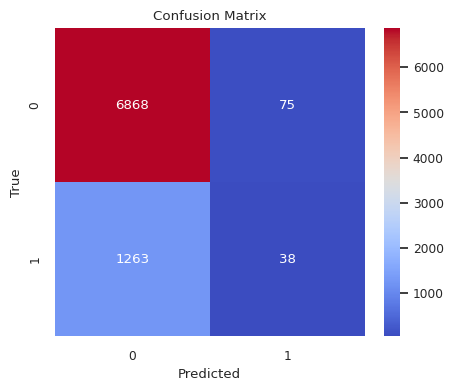

In [36]:
melhor_modelo = encontra_melhor_modelo(X_train, X_test, y_train, y_test, 'roc_auc')

# UNDERSAMPLING

Remove-se amostras aleatoriamente da classe majoritária (target_default = 0) para que a quantidade seja igual a da classe minoritária (target_default = 1).

In [37]:
# Class count
df_train = pd.concat([X_train, y_train], axis=1)
count_class_0, count_class_1 = df_train[lbl_y].value_counts()

# Divide by class
df_class_0 = df_train[df_train[lbl_y] == 0]
df_class_1 = df_train[df_train[lbl_y] == 1]

In [38]:
df_class_0_under = df_class_0.sample(count_class_1, random_state=42)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under[lbl_y].value_counts())

Random under-sampling:
0    5287
1    5287
Name: target_default, dtype: int64


In [39]:
# separar as variáveis independentes da variável alvo
X_train_under = df_train_under.drop(lbl_y, axis=1)
y_train_under = df_train_under[lbl_y]

Performance dos Modelos:
Logistic Regression - roc_auc: 0.60814
Random Forest - roc_auc: 0.59334
Gradient Boosting - roc_auc: 0.61946

Melhor modelo: Gradient Boosting com roc_auc: 0.6195
Acurácia: 0.6468.
Acurácia Balanceada: 0.6195.
Precisão: 0.2417.
Recall: 0.5796.
Especificidade: 0.6594.
F1: 0.3412.
ROC AUC: 0.6195
KS: 0.2389 (p-value: 1.956e-55)




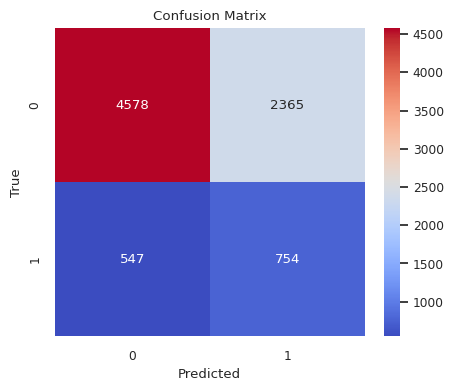

In [40]:
melhor_modelo = encontra_melhor_modelo(X_train_under, X_test, y_train_under, y_test, 'roc_auc')

In [41]:
melhor_modelo.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# OVERSAMPLING

Duplica-se amostras aleatoriamente da classe minoritária (target_default = 1) para que a quantidade seja igual a da classe majoritária (target_default = 0).

In [42]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True, random_state= 42)
df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_train_over[lbl_y].value_counts())

Random over-sampling:
0    27687
1    27687
Name: target_default, dtype: int64


In [43]:
# separar as variáveis independentes da variável alvo
X_train_over = df_train_over.drop(lbl_y, axis=1)
y_train_over = df_train_over[lbl_y]

Performance dos Modelos:
Logistic Regression - roc_auc: 0.60703
Random Forest - roc_auc: 0.52158
Gradient Boosting - roc_auc: 0.62529

Melhor modelo: Gradient Boosting com roc_auc: 0.6253
Acurácia: 0.6708.
Acurácia Balanceada: 0.6253.
Precisão: 0.2536.
Recall: 0.5588.
Especificidade: 0.6918.
F1: 0.3488.
ROC AUC: 0.6253
KS: 0.2506 (p-value: 5.365e-61)




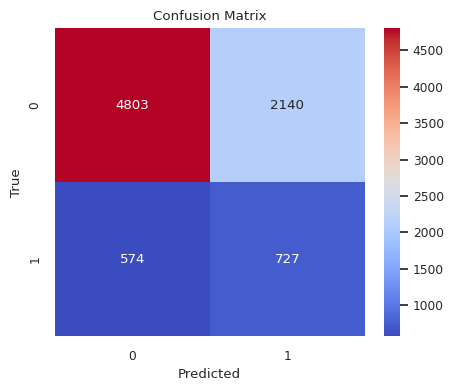

In [44]:
melhor_modelo = encontra_melhor_modelo(X_train_over, X_test, y_train_over, y_test, 'roc_auc')

# VISUALIZANDO OS SCORES


In [154]:
df_test = X_test.copy()
df_test['y_proba'] = melhor_modelo.predict_proba(X_test)[:,0]
df_test['y_pred'] = melhor_modelo.predict(X_test)
df_test['y_test'] = y_test

In [155]:
n_bins = 10
df_test['faixa_score'] = pd.qcut(df_test['y_proba'], n_bins, retbins=True)[0]
ser, bins = pd.qcut(df_test['y_proba'], n_bins, retbins=True)
print('\n', pd.crosstab(df_test['faixa_score'], df_test['y_pred'], rownames=['Actual'], colnames=['y_pred'], margins=True))
print('\n', pd.crosstab(df_test['faixa_score'], df_test['y_pred'], rownames=['Actual'], colnames=['y_pred'], margins=True, normalize='all'))


 y_pred             0     1   All
Actual                          
(0.123, 0.355]     0   825   825
(0.355, 0.397]     0   824   824
(0.397, 0.465]     0   824   824
(0.465, 0.519]   431   394   825
(0.519, 0.549]   824     0   824
(0.549, 0.576]   824     0   824
(0.576, 0.6]     825     0   825
(0.6, 0.632]     824     0   824
(0.632, 0.672]   824     0   824
(0.672, 0.915]   825     0   825
All             5377  2867  8244

 y_pred                 0         1       All
Actual                                      
(0.123, 0.355]  0.000000  0.100073  0.100073
(0.355, 0.397]  0.000000  0.099951  0.099951
(0.397, 0.465]  0.000000  0.099951  0.099951
(0.465, 0.519]  0.052280  0.047792  0.100073
(0.519, 0.549]  0.099951  0.000000  0.099951
(0.549, 0.576]  0.099951  0.000000  0.099951
(0.576, 0.6]    0.100073  0.000000  0.100073
(0.6, 0.632]    0.099951  0.000000  0.099951
(0.632, 0.672]  0.099951  0.000000  0.099951
(0.672, 0.915]  0.100073  0.000000  0.100073
All             0.652232  0

In [157]:
cm = metrics.confusion_matrix(df_test['y_test'], df_test['y_pred'])

print('Não Default Carteira: ',cm[0].sum()/cm.sum())
print('Default Carteira: ',cm[1].sum()/cm.sum())
print('\n')
print('Não Default Predito: ',(cm[0][0]+cm[1][0])/cm.sum())
print('Default Predito: ',(cm[0][1]+cm[1][1])/cm.sum())

print('\nErro:')
print('Clientes bons com crédito negado: ', (cm[0][1]/cm.sum()))
print('Clientes ruins com crédito aprovado: ', (cm[1][0]/cm.sum()))

Não Default Carteira:  0.8421882581271227
Default Carteira:  0.15781174187287725


Não Default Predito:  0.6522319262493935
Default Predito:  0.3477680737506065

Erro:
Clientes bons com crédito negado:  0.25958272683163514
Clientes ruins com crédito aprovado:  0.06962639495390587


Dado baixo nível de acertos do modelo temos um alto número de clientes que teriam crédito negado considerando o ponto de corte para o score em 50% de probabilidade de default.

# DECISÃO DE NEGÓCIO

Qual seria o ponto de corte em que concedemos mais crédito e mantemos o mix de defaults na carteira de crédito como na base de treinamento (imaginando que se trata de uma captura de um período anterior)?

1321 marcados como default no ponto de corte 0.381 



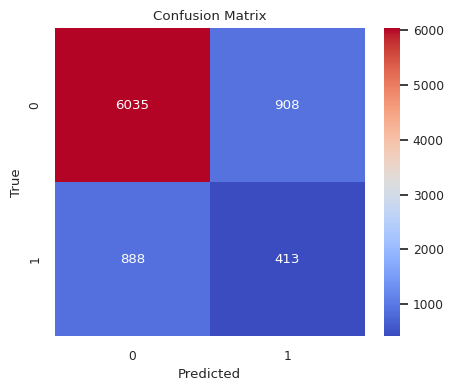


Acurácia: 0.7821.
Acurácia Balanceada: 0.5933.
Precisão: 0.3126.
Recall: 0.3174.
Especificidade: 0.8692.
F1: 0.3150.
ROC AUC: 0.5933

Não Default Carteira:  0.8421882581271227
Default Carteira:  0.15781174187287725


Não Default Predito:  0.8397622513343037
Default Predito:  0.16023774866569626

Erro:
Clientes bons com crédito negado:  0.1101407083939835
Clientes ruins com crédito aprovado:  0.10771470160116449


In [162]:
defaults = df_test[df_test['y_test'] == 1]['y_test'].count()

df_test2 = df_test.copy()

for i in range(500,0,-1):
  pc = i/1000
  df_test2['y_pred'] = 0
  df_test2.loc[df_test2['y_proba'] < pc, 'y_pred'] = 1

  cm2 = metrics.confusion_matrix(df_test2['y_test'], df_test2['y_pred'])
  default_temp = (cm2[0][1]+cm2[1][1])

  if default_temp >= defaults:
     default_final = default_temp
     pc_final = pc

print(f'{default_final} marcados como default no ponto de corte {pc_final} \n')

df_test2['y_pred'] = 0
df_test2.loc[df_test2['y_proba'] < pc_final, 'y_pred'] = 1
cm = metrics.confusion_matrix(df_test2['y_test'], df_test2['y_pred'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

accuracy = metrics.accuracy_score(df_test2['y_test'], df_test2['y_pred'])
balanced_accuracy = metrics.balanced_accuracy_score(df_test2['y_test'], df_test2['y_pred'])
precision = metrics.precision_score(df_test2['y_test'], df_test2['y_pred'])
recall = metrics.recall_score(df_test2['y_test'], df_test2['y_pred'])
specificity = metrics.recall_score(df_test2['y_test'], df_test2['y_pred'], pos_label=0)
f1 = metrics.f1_score(df_test2['y_test'], df_test2['y_pred'])
roc_auc = metrics.roc_auc_score(df_test2['y_test'], df_test2['y_pred'])

print(f"\nAcurácia: {accuracy:.4f}.")
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}.")
print(f"Precisão: {precision:.4f}.")
print(f"Recall: {recall:.4f}.")
print(f"Especificidade: {specificity:.4f}.")
print(f"F1: {f1:.4f}.")
print(f"ROC AUC: {roc_auc:.4f}")

cm = metrics.confusion_matrix(df_test2['y_test'], df_test2['y_pred'])

print('\nNão Default Carteira: ',cm[0].sum()/cm.sum())
print('Default Carteira: ',cm[1].sum()/cm.sum())
print('\n')
print('Não Default Predito: ',(cm[0][0]+cm[1][0])/cm.sum())
print('Default Predito: ',(cm[0][1]+cm[1][1])/cm.sum())

print('\nErro:')
print('Clientes bons com crédito negado: ', (cm[0][1]/cm.sum()))
print('Clientes ruins com crédito aprovado: ', (cm[1][0]/cm.sum()))

# CONCLUSÃO

Apesar da numerosa quantidade de features disponíveis na base de dados, não foi possível obter mais informações sobre a sistemática de origem destes dados. Portanto para o treinamento do modelo temos um número reduzido de features.

Na análise de correlação com a variável target, não foram identificados correlações fortes ou até mesmo medianas, ressaltando a necessidade da inclusão de mais features para treinamento. Houve a tentativa de otimização dos hiperparâmetros proém não foram encontrdos melhoras signficativas nos scores.

Com relação aos problemas encontrados na amostra (desbalanceamento da variável target) foram testados dois métodos sendo eles: o UnderSampling que busca reduzir a amostra da classe majoritaria e o OverSampling que busca duplicar a amostra da classe minoritária.

Foram obtidos resultados satisfatórios com relação ao modelo inicialmente proposto, tendo o KS e AUC aumentado consideravelmente.

* Desbalanceado<br>
KS: 0.0635 - ROC AUC: 0.5032

* UnderSampling<br>
KS: 0.2389 - ROC AUC: 0.6195

* OverSampling<br>
KS: 0.2506 - ROC AUC: 0.6253

Estudando as faixas de probabilidade geradas, podemos verificar uma grande proporção da amostra de "bons clientes" sendo marcados como "ruins", desta forma o negócio deixaria dinheiro na mesa. Foi proposto um novo ponto de corte que concede mais crédito (e consequentemente também para clientes que podem entrar em default) mas que mantém a proporção de crédito ruim na carteira da instituição financeira.

